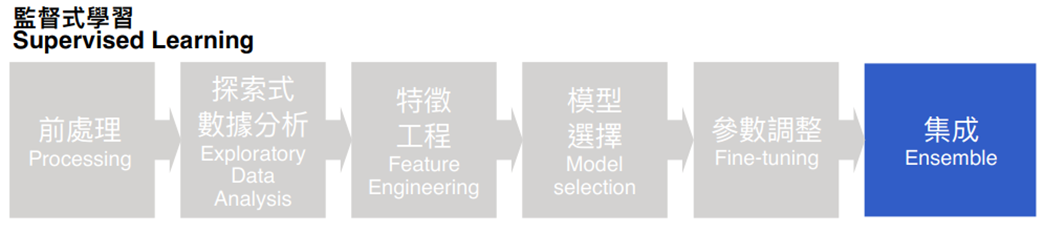

In [1]:
import os
import numpy as np
import pandas as pd
#前處理
from sklearn.preprocessing import StandardScaler,MinMaxScaler,OneHotEncoder
#模型
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
import warnings
warnings.filterwarnings('ignore')

In [2]:
DATA_ROOT = "./pm/"
print(os.listdir("./pm"))

['2014.csv', '2015.csv', '2016.csv', 'd2017.csv', 'd2018.csv', 'Demo_test.csv', 'pm.csv', 'pm2014.csv', 'pm2015.csv', 'pm2016.csv', 'pm2017.csv', 'pm2018.csv', 'pmall.csv', 'pmmergeclean.csv', 'pmtest.csv', 'pmtest1.csv', 'pm_train.csv', 'test.csv', '空氣品質監測小時值.csv', '空氣品質監測小時值xxx.csv', '離群值.PNG', '離群值2.PNG']


In [3]:
#此處先手動清理PM2.5中有異常文字型態的資料及大量空缺值
dataclean = pd.read_csv(os.path.join(DATA_ROOT,'pmmergeclean.csv'), encoding='big5')
print(dataclean['PM2.5'].dtype)
daidx,col = dataclean.shape
print(f'資料維度:{daidx,col}')
dataclean.head(3)

int64
資料維度:(2587, 19)


,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,2018/6/30,0,4
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,2018/6/30,1,9
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2018/6/30,2,6


In [4]:
intfloat_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'int64' or dtype =='float64':
        intfloat_feature.append(feature)
object_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'object':
        object_feature.append(feature)
print(f'Num_feature:{intfloat_feature}')
print(f'Obj_feature:{object_feature}')

Num_feature:['NOx', 'WIND_DIREC', 'O3', 'NMHC', 'CO', 'NO', 'NO2', 'RH', 'PM10', 'CH4', 'WIND_SPEED', 'AMB_TEMP', 'THC', 'WS_HR', 'WD_HR', 'SO2', 'Hour', 'PM2.5']
Obj_feature:['DATE']


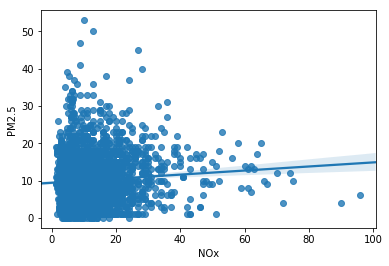

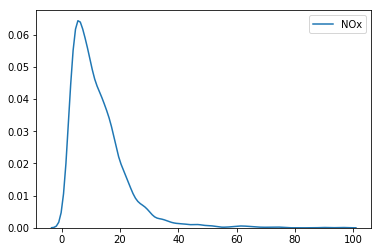

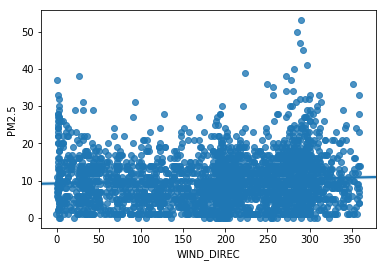

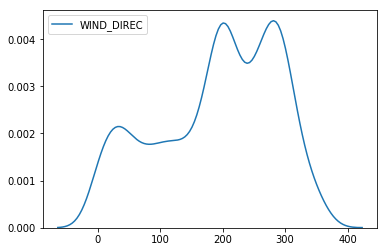

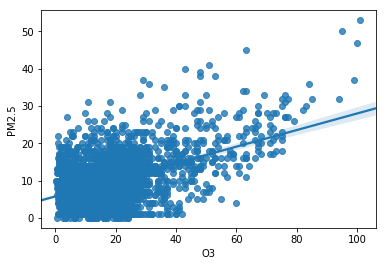

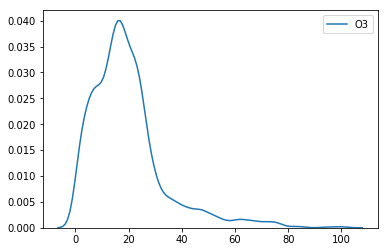

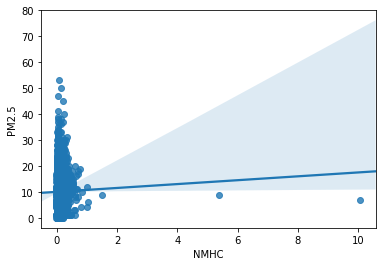

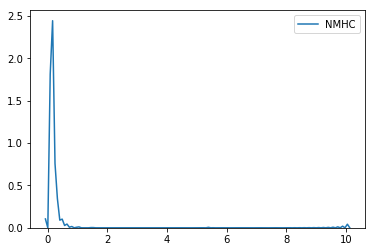

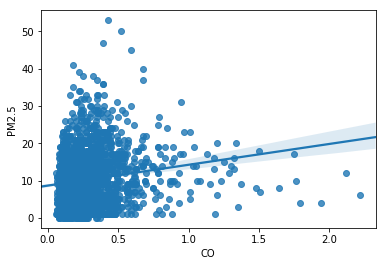

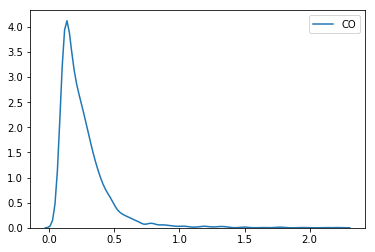

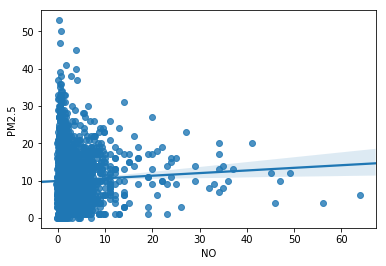

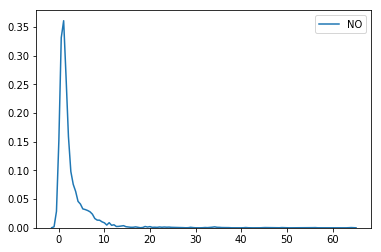

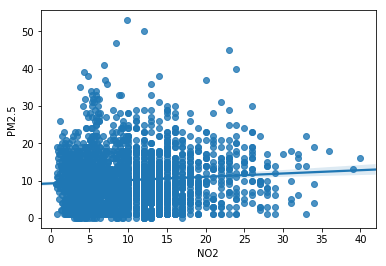

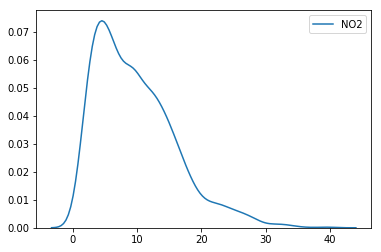

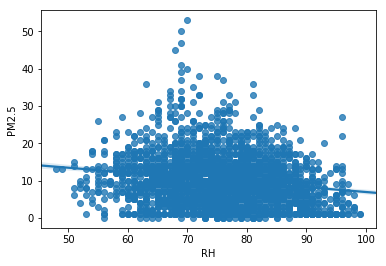

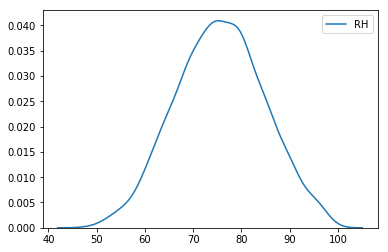

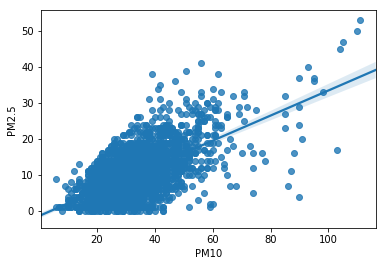

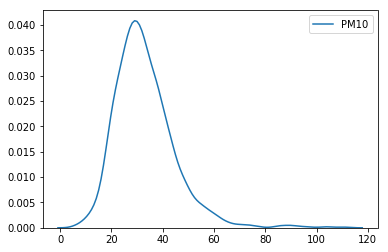

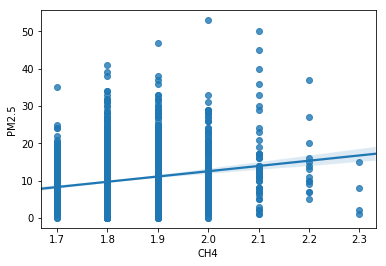

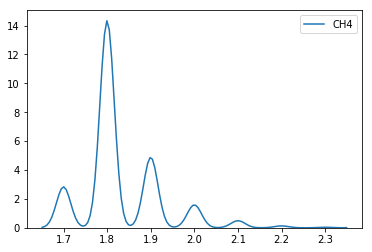

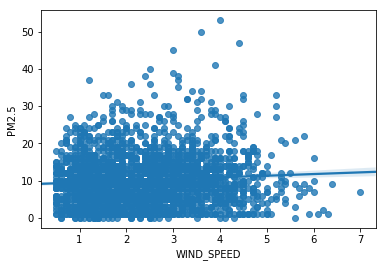

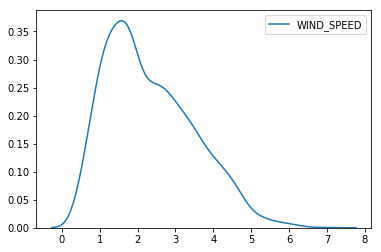

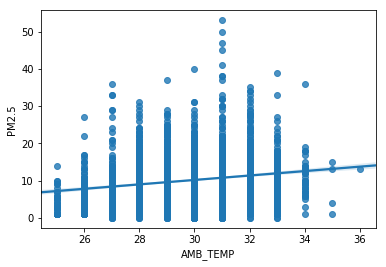

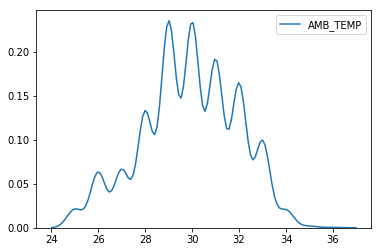

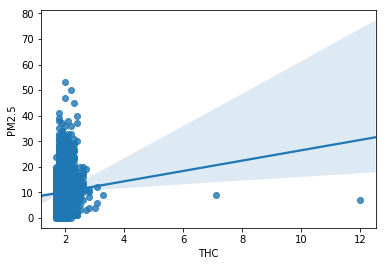

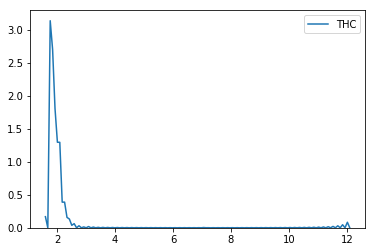

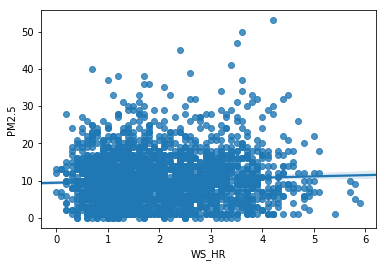

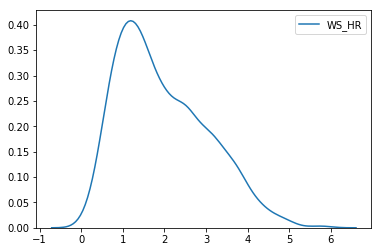

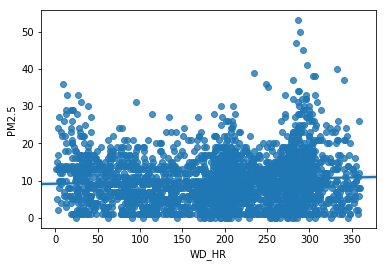

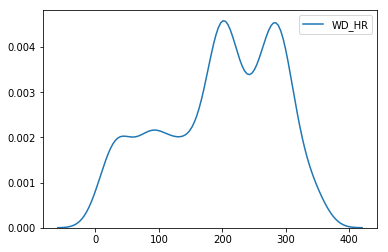

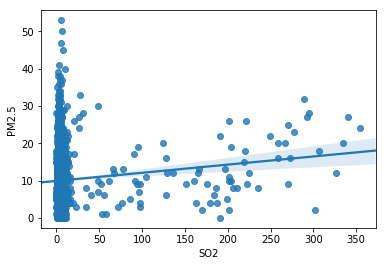

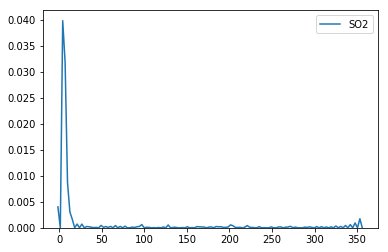

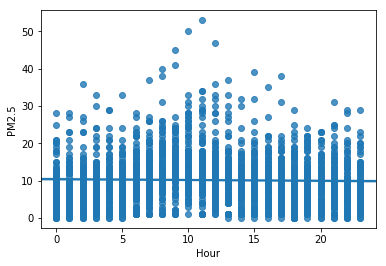

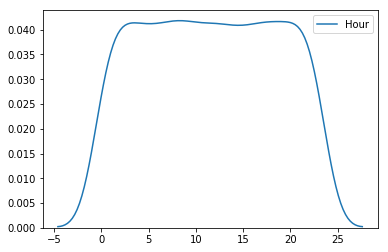

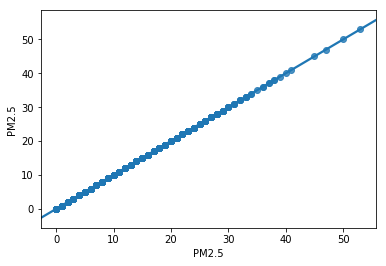

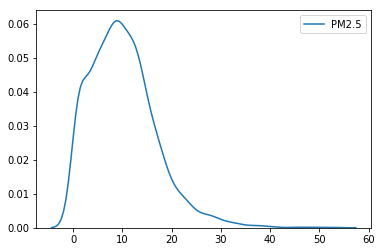

In [5]:
'''查看分布有無超界值'''
'''需補完值才能做清除的步驟，否則也會把NaN值給清除'''
pm25 = dataclean['PM2.5']

for i in intfloat_feature:
    sns.regplot(x = dataclean[i],y = pm25)
    plt.show()
    sns.kdeplot(dataclean[i])
    plt.show()


In [6]:
'''NAN也會被刪除'''
keep_index = (dataclean['NMHC']<5) | (dataclean['NMHC']>0)
b=dataclean[~keep_index]
b.head(4)
#keep_index = (dataclean['NMHC']<5)
#dataclean = dataclean[keep_index]

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.0,58.0,NaN,3.9,31.0,NaN,3.6,284.0,259.0,2018/6/13,14,16
847,8.9,264.0,23.0,NaN,0.12,0.5,8.5,75.0,70.0,NaN,2.4,31.0,NaN,2.0,281.0,3.7,2017/6/23,17,16
959,5.9,245.0,19.0,NaN,0.12,1.4,4.5,75.0,33.0,NaN,4.1,31.0,NaN,2.4,245.0,NaN,2017/6/16,13,4
1167,NaN,293.0,NaN,NaN,NaN,NaN,NaN,NaN,36.0,NaN,2.6,NaN,NaN,NaN,NaN,NaN,2017/6/5,15,15


In [7]:
Demo_test = pd.read_csv(os.path.join(DATA_ROOT,'Demo_test.csv'), encoding='big5')
print(Demo_test['PM2.5'].dtype)
Ddaidx,Dcol = Demo_test.shape
print(f'資料維度:{Ddaidx,Dcol}')
Demo_test.head(3)

int64
資料維度:(120, 19)


,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
0,17.0,70.0,19.0,0.13,0.43,1.3,16.0,82,16.0,1.9,1.7,28.5,2.0,1.3,93.0,2.0,2019/6/1,0,6
1,14.0,74.0,21.0,0.12,0.33,1.6,13.0,82,22.0,1.9,2.0,28.3,2.1,1.5,76.0,2.9,2019/6/1,1,11
2,10.0,119.0,23.0,0.08,0.28,1.5,9.0,85,21.0,1.9,1.3,27.9,2.0,1.1,94.0,1.6,2019/6/1,2,8


In [8]:
'''資料合併'''
dataclean = pd.concat([dataclean,Demo_test],axis = 0,sort = False)
dataclean =dataclean.reset_index(drop = True)
print(f'combined dataclean shape = {dataclean.shape}')
dataclean.tail(3)

combined dataclean shape = (2707, 19)


,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,DATE,Hour,PM2.5
2704,56.0,22.0,1.3,0.74,0.90,30.0,26.0,86.0,35.0,1.9,0.5,27.3,2.7,0.7,22.0,7.5,2019/6/4,21,10
2705,62.0,184.0,1.5,0.67,1.26,39.0,23.0,87.0,36.0,1.9,0.8,27.3,2.6,0.1,191.0,7.6,2019/6/4,22,8
2706,61.0,97.0,1.4,0.57,1.15,39.0,22.0,86.0,39.0,2.0,0.8,27.1,2.6,0.7,50.0,7.0,2019/6/4,23,11


In [9]:
'''特徵衍生'''
dataclean['DATE'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strptime(x, '%Y/%m/%d'))
dataclean['YEAR'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%Y')).astype('int64')#or object
dataclean['MONTH'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%m')).astype('int64')#or object
#dataclean['DAY'] = dataclean['DATE'].apply(lambda x: datetime.datetime.strftime(x, '%d')).astype('int64')# use object
#dataclean['WEEK'] = dataclean['DATE'].apply(lambda x:datetime.datetime.strftime(x, '%A')).astype('object')
dataclean['WEEK_NUM'] = dataclean['DATE'].apply(lambda x:datetime.datetime.strftime(x,'%w')).astype('object')
dataclean = dataclean.drop(['DATE'],axis = 1)
dataclean = dataclean.drop(['YEAR'],axis = 1)
dataclean = dataclean.drop(['MONTH'],axis = 1)
dataclean.head(3)

,NOx,WIND_DIREC,O3,NMHC,CO,NO,NO2,RH,PM10,CH4,WIND_SPEED,AMB_TEMP,THC,WS_HR,WD_HR,SO2,Hour,PM2.5,WEEK_NUM
0,5.4,258.0,9.7,0.01,0.10,0.7,4.7,77.0,16.0,1.7,1.7,29.0,1.7,1.2,253.0,1.5,0,4,6
1,4.3,258.0,14.0,0.00,0.09,0.2,4.1,77.0,14.0,1.7,1.4,29.0,1.7,1.3,256.0,1.0,1,9,6
2,3.3,265.0,16.0,0.00,0.09,-0.1,3.4,80.0,17.0,1.7,0.8,29.0,1.7,1.2,256.0,0.6,2,6,6


In [10]:
'''查看有無缺失值'''
dataclean.isnull().any().values

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True, False, False,
       False])

In [11]:
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
print(na_check(dataclean))

,Missing Ratio
SO2,1.736239
AMB_TEMP,1.108238
THC,0.554119
CH4,0.554119
NMHC,0.554119
NO2,0.480236
NO,0.480236
NOx,0.480236
O3,0.332471
CO,0.295530


None


In [12]:
intfloat_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'int64' or dtype =='float64':
        intfloat_feature.append(feature)
object_feature = []
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    if dtype == 'object':
        object_feature.append(feature)
print(f'Num_feature:{intfloat_feature}')
print(f'Obj_feature:{object_feature}')

Num_feature:['NOx', 'WIND_DIREC', 'O3', 'NMHC', 'CO', 'NO', 'NO2', 'RH', 'PM10', 'CH4', 'WIND_SPEED', 'AMB_TEMP', 'THC', 'WS_HR', 'WD_HR', 'SO2', 'Hour', 'PM2.5']
Obj_feature:['WEEK_NUM']


In [13]:
'''遺失值補值，以眾數補值'''
'''這邊假入測試集為空白時，測試集的PM2.5也會被補到，但不影響'''
for dtype,feature in zip(dataclean.dtypes,dataclean.columns):
    
    if dtype == 'float64' or dtype =='int64':
        #處理負值
        negidx = dataclean.loc[:][feature]<0
        #dataclean.loc[negidx,feature]  = (dataclean[feature].mode()[0]+dataclean[feature].describe()['mean'])/2 #以眾數與平均值的平均取代      
        dataclean.loc[negidx,feature]  = (dataclean[feature].mode()[0])
        #處理空缺值
        dataclean[feature].fillna(dataclean[feature].mode()[0], inplace=True)

In [14]:
'''查看有無缺失值'''
print(dataclean.isnull().any().values)
print(na_check(dataclean))

[False False False False False False False False False False False False
 False False False False False False False]


,Missing Ratio


None


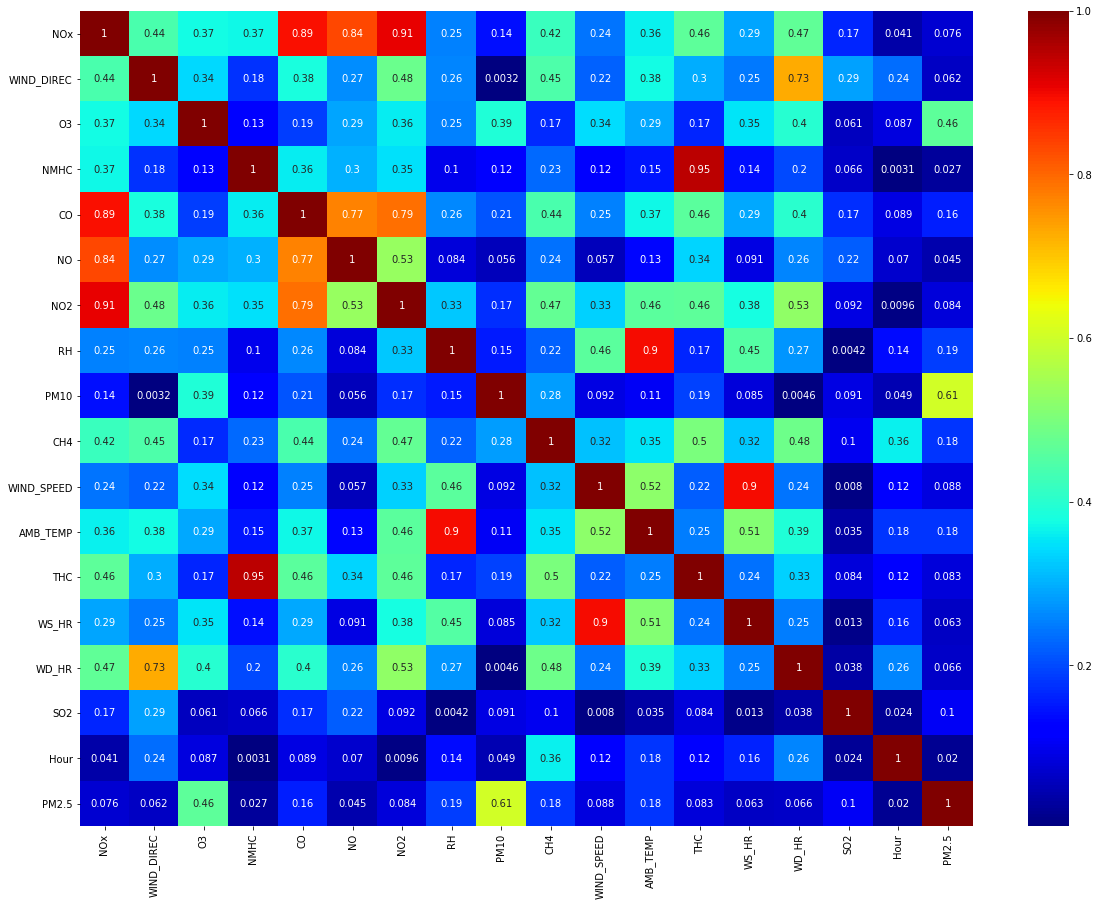

In [15]:
'''自變數相似度'''
corr_mat = dataclean.corr().abs()
plt.subplots(figsize = (20,15))
sns.heatmap(corr_mat,cmap = 'jet',annot = True)

In [16]:
'''消除自變數相關性高的特徵'''
upper = corr_mat.where(np.triu(np.ones(corr_mat.shape),k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column]>0.75)]
print(to_drop)
dataclean.drop(to_drop,axis =1 ,inplace = True)
print(f'dataclean shape:{dataclean.shape}')
dataclean.head(3)

['CO', 'NO', 'NO2', 'AMB_TEMP', 'THC', 'WS_HR']
dataclean shape:(2707, 13)


,NOx,WIND_DIREC,O3,NMHC,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,PM2.5,WEEK_NUM
0,5.4,258.0,9.7,0.01,77.0,16.0,1.7,1.7,253.0,1.5,0,4,6
1,4.3,258.0,14.0,0.00,77.0,14.0,1.7,1.4,256.0,1.0,1,9,6
2,3.3,265.0,16.0,0.00,80.0,17.0,1.7,0.8,256.0,0.6,2,6,6


In [17]:
'''資料分割，清除訓練集資料的超界值'''
train = dataclean[:daidx]
test = dataclean[daidx:]
print(f'train shape:{train.shape}')
print(f'test shape:{test.shape}')

train shape:(2587, 13)
test shape:(120, 13)


In [18]:
'''消除超界值資料'''
keep_index = (train['NMHC']<5)
train = train[keep_index]
new_daidx = train.shape[0]
print(f'train shape:{train.shape}')
print(f'test shape:{test.shape}')

train shape:(2585, 13)
test shape:(120, 13)


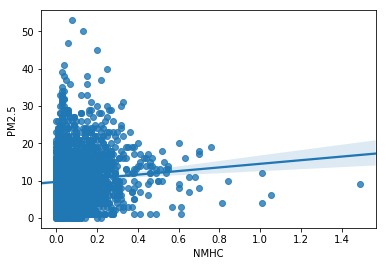

In [19]:
'''顯示刪除後結果'''
pm25=train['PM2.5']
sns.regplot(x = train['NMHC'],y = pm25)
plt.show()

In [20]:
pm25 = train['PM2.5']
test_pm25 = test['PM2.5']
train.drop(['PM2.5'],axis = 1,inplace = True)
print(f'train shape:{train.shape}')
train.head(3)

train shape:(2585, 12)


,NOx,WIND_DIREC,O3,NMHC,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,WEEK_NUM
0,5.4,258.0,9.7,0.01,77.0,16.0,1.7,1.7,253.0,1.5,0,6
1,4.3,258.0,14.0,0.00,77.0,14.0,1.7,1.4,256.0,1.0,1,6
2,3.3,265.0,16.0,0.00,80.0,17.0,1.7,0.8,256.0,0.6,2,6


In [21]:
'''再次特徵篩選'''
from sklearn.linear_model import Lasso
L1_Reg = Lasso(alpha=0.01)
L1_Reg.fit(train, pm25)
L1_Reg.coef_

array([ 9.61575678e-02,  3.13028417e-03,  1.58411112e-01, -0.00000000e+00,
       -8.64144989e-02,  2.44980123e-01,  4.67241295e+00, -4.11808302e-01,
        1.02414402e-05,  5.99335996e-03, -2.92849780e-02,  9.11866433e-02])

In [22]:
from itertools import compress
L1_mask = list((L1_Reg.coef_>0) | (L1_Reg.coef_<0))
L1_list = list(compress(list(train), list(L1_mask)))
L1_list

['NOx',
 'WIND_DIREC',
 'O3',
 'RH',
 'PM10',
 'CH4',
 'WIND_SPEED',
 'WD_HR',
 'SO2',
 'Hour',
 'WEEK_NUM']

In [23]:
train= train[L1_list]
train.head(3)

,NOx,WIND_DIREC,O3,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,WEEK_NUM
0,5.4,258.0,9.7,77.0,16.0,1.7,1.7,253.0,1.5,0,6
1,4.3,258.0,14.0,77.0,14.0,1.7,1.4,256.0,1.0,1,6
2,3.3,265.0,16.0,80.0,17.0,1.7,0.8,256.0,0.6,2,6


In [24]:
test = test[L1_list]
test.head(3)

,NOx,WIND_DIREC,O3,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,WEEK_NUM
2587,17.0,70.0,19.0,82.0,16.0,1.9,1.7,93.0,2.0,0,6
2588,14.0,74.0,21.0,82.0,22.0,1.9,2.0,76.0,2.9,1,6
2589,10.0,119.0,23.0,85.0,21.0,1.9,1.3,94.0,1.6,2,6


In [25]:
'''重新合併資料'''
data_merge = pd.concat([train,test],axis = 0,sort = False)
print(f'data_merge shape:{data_merge.shape}')
data_merge.head(5)
#PM25 = data_merge['PM2.5']
#print(f'PM25 shape:{PM25.shape}')
#data_merge.drop(['PM2.5'],axis = 1,inplace = True)
#print(f'data_merge shape:{data_merge.shape}')

data_merge shape:(2705, 11)


,NOx,WIND_DIREC,O3,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,WEEK_NUM
0,5.4,258.0,9.7,77.0,16.0,1.7,1.7,253.0,1.5,0,6
1,4.3,258.0,14.0,77.0,14.0,1.7,1.4,256.0,1.0,1,6
2,3.3,265.0,16.0,80.0,17.0,1.7,0.8,256.0,0.6,2,6
3,2.9,248.0,16.0,81.0,18.0,1.7,0.9,272.0,0.0,3,6
4,2.3,258.0,19.0,80.0,21.0,1.7,0.8,263.0,0.0,4,6


In [26]:
intfloat_feature = []
for dtype,feature in zip(data_merge.dtypes,data_merge.columns):
    if dtype == 'int64' or dtype =='float64':
        intfloat_feature.append(feature)
object_feature = []
for dtype,feature in zip(data_merge.dtypes,data_merge.columns):
    if dtype == 'object':
        object_feature.append(feature)
print(f'Num_feature:{intfloat_feature}')
print(f'Obj_feature:{object_feature}')

Num_feature:['NOx', 'WIND_DIREC', 'O3', 'RH', 'PM10', 'CH4', 'WIND_SPEED', 'WD_HR', 'SO2', 'Hour']
Obj_feature:['WEEK_NUM']


In [27]:
'''特徵轉換'''
MMEncoder = MinMaxScaler()
OHEncoder = OneHotEncoder()
SDEncoder = StandardScaler()
#風向、每小時風向之角度轉成徑度
data_merge['WIND_DIREC'] = data_merge['WIND_DIREC'].apply(lambda x: math.radians(x))
data_merge['WD_HR'] = data_merge['WD_HR'].apply(lambda x: math.radians(x))
for i in intfloat_feature:
    data_merge[i] = MMEncoder.fit_transform(data_merge[i].values.reshape(-1,1))
data_merge = pd.get_dummies(data_merge)
print(f'data_merge shape:{data_merge.shape}')
data_merge.head(3)

data_merge shape:(2705, 17)


,NOx,WIND_DIREC,O3,RH,PM10,CH4,WIND_SPEED,WD_HR,SO2,Hour,WEEK_NUM_0,WEEK_NUM_1,WEEK_NUM_2,WEEK_NUM_3,WEEK_NUM_4,WEEK_NUM_5,WEEK_NUM_6
0,0.042283,0.716194,0.093347,0.568627,0.136364,0.0,0.184615,0.702447,0.004225,0.000000,0,0,0,0,0,0,1
1,0.030655,0.716194,0.136048,0.568627,0.118182,0.0,0.138462,0.710790,0.002817,0.043478,0,0,0,0,0,0,1
2,0.020085,0.735671,0.155909,0.627451,0.145455,0.0,0.046154,0.710790,0.001690,0.086957,0,0,0,0,0,0,1


In [28]:
'''分割資料開始訓練模型'''
train_X = data_merge[:new_daidx]
train_Y = pm25
test_X = data_merge[new_daidx:]
test_Y = test_pm25
print(f'train_X shape:{train_X.shape}')
print(f'train_Y shape:{train_Y.shape}')
print(f'test_X shape:{test_X.shape}')
print(f'test_Y shape:{test_Y.shape}')

train_X shape:(2585, 17)
train_Y shape:(2585,)
test_X shape:(120, 17)
test_Y shape:(120,)


In [29]:
gdbt = GradientBoostingRegressor(random_state=7)
tol = [0.1,0.01,0.001]
subsample = [0.2,0.4,0.6]
n_estimators=[200,300,400]
max_features= [2,4,5]
max_depth = [4,6,7]
learning_rate=[0.01,0.03,0.005]
param_grid_gbdt = dict(tol = tol,subsample=subsample,n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,learning_rate=learning_rate)


In [30]:
grid_search_gdbt = GridSearchCV(gdbt, param_grid_gbdt, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_result_gdbt = grid_search_gdbt.fit(train_X, train_Y)


Fitting 3 folds for each of 729 candidates, totalling 2187 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   36.8s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   55.1s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2187 out of 2187 | elapsed:  1.7min finished


In [31]:
print("Best Accuracy: %f using %s" % (grid_result_gdbt.best_score_, grid_result_gdbt.best_params_))

Best Accuracy: -28.542247 using {'learning_rate': 0.03, 'max_depth': 4, 'max_features': 5, 'n_estimators': 200, 'subsample': 0.4, 'tol': 0.1}


In [32]:
gdbt_bestparam = GradientBoostingRegressor(learning_rate=grid_result_gdbt.best_params_['learning_rate'],max_depth=grid_result_gdbt.best_params_['max_depth'],
                                          max_features=grid_result_gdbt.best_params_['max_features'],n_estimators=grid_result_gdbt.best_params_['n_estimators'],
                                          subsample=grid_result_gdbt.best_params_['subsample'],tol=grid_result_gdbt.best_params_['tol'],random_state=7)

In [33]:
rf = RandomForestRegressor(random_state=7,bootstrap=False)
n_estimators=[200,300,400]
min_samples_split=[5,10,15]
min_samples_leaf=[5,10,15]
max_features=['sqrt','auto','log2']
max_depth=[6,10,15]
param_grid_rf = dict(n_estimators=n_estimators,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf
                    ,max_features=max_features,max_depth=max_depth)

In [34]:
grid_search_rf = GridSearchCV(rf, param_grid_rf, scoring="neg_mean_squared_error", n_jobs=-1, verbose=1)
grid_result_rf = grid_search_rf.fit(train_X, train_Y)

Fitting 3 folds for each of 243 candidates, totalling 729 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   22.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 729 out of 729 | elapsed:  1.7min finished


In [35]:
print("Best Accuracy: %f using %s" % (grid_result_rf.best_score_, grid_result_rf.best_params_))

Best Accuracy: -29.785975 using {'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 5, 'n_estimators': 200}


In [36]:
rf_bestparam = RandomForestRegressor(n_estimators=grid_result_rf.best_params_['n_estimators'],min_samples_split=grid_result_rf.best_params_['min_samples_split'],min_samples_leaf=grid_result_rf.best_params_['min_samples_leaf'],
                                    max_features=grid_result_rf.best_params_['max_features'],max_depth=grid_result_rf.best_params_['max_depth'],random_state=7,bootstrap=False)

In [37]:
'''各自模型預測'''
gdbt_bestparam.fit(train_X,train_Y)
gdbt_pred = gdbt_bestparam.predict(test_X)
print(f"gdbt Mean squared error: {mean_squared_error(test_Y,gdbt_pred)}")
rf_bestparam.fit(train_X,train_Y)
rf_pred = rf_bestparam.predict(test_X)
print(f"rf Mean squared error: {mean_squared_error(test_Y,rf_pred)}")

gdbt Mean squared error: 19.9246661937386
rf Mean squared error: 19.43937165273224


In [38]:
linear = LinearRegression(normalize=False, fit_intercept=True, copy_X=True)
linear.fit(train_X,train_Y)
linear_pred = linear.predict(test_X)
print(f"linear Mean squared error: {mean_squared_error(test_Y,linear_pred)}")

linear Mean squared error: 23.9099853515625


In [39]:
'''混合模型預測'''
blend_pred1 = 0.1*linear_pred+0.3*rf_pred+0.6*gdbt_pred
blend_pred2 = 0.3*linear_pred+0.6*rf_pred+0.1*gdbt_pred
blend_pred3 = 0.6*linear_pred+0.1*rf_pred+0.3*gdbt_pred
blend_pred4 = 0.5*rf_pred+0.5*gdbt_pred
blend_pred5 = 0.4*linear_pred+0.6*rf_pred
blend_pred6 = 0.6*linear_pred+0.4*rf_pred
print(f"blend_pred1 Mean squared error: {mean_squared_error(test_Y,blend_pred1)}")
print(f"blend_pred2 Mean squared error: {mean_squared_error(test_Y,blend_pred2)}")
print(f"blend_pred3 Mean squared error: {mean_squared_error(test_Y,blend_pred3)}")
print(f"blend_pred4 Mean squared error: {mean_squared_error(test_Y,blend_pred4)}")
print(f"blend_pred5 Mean squared error: {mean_squared_error(test_Y,blend_pred5)}")
print(f"blend_pred6 Mean squared error: {mean_squared_error(test_Y,blend_pred6)}")

blend_pred1 Mean squared error: 19.367824550243405
blend_pred2 Mean squared error: 19.069250375321687
blend_pred3 Mean squared error: 20.43893946387267
blend_pred4 Mean squared error: 19.510028158694126
blend_pred5 Mean squared error: 19.226771845839053
blend_pred6 Mean squared error: 20.120894585605104


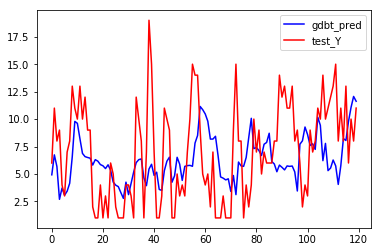

In [40]:
p_test_Y = test_Y.reset_index(drop=True)
plt.plot(gdbt_pred,'b',label ='gdbt_pred' )
plt.plot(p_test_Y,'r',label ='test_Y')
plt.legend()

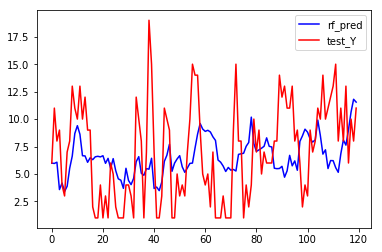

In [41]:
plt.plot(rf_pred,'b',label ='rf_pred' )
plt.plot(p_test_Y,'r',label ='test_Y')
plt.legend()

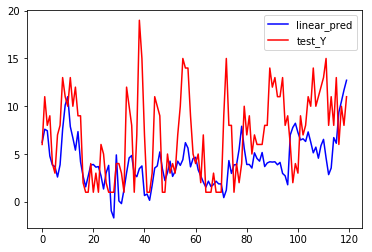

In [42]:
plt.plot(linear_pred,'b',label ='linear_pred' )
plt.plot(p_test_Y,'r',label ='test_Y')
plt.legend()

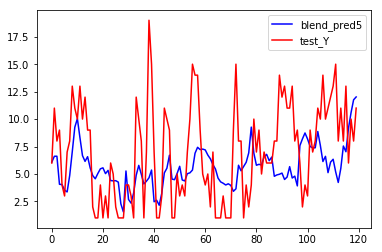

In [43]:
plt.plot(blend_pred5,'b',label ='blend_pred5' )
plt.plot(p_test_Y,'r',label ='test_Y')
plt.legend()